In [1]:
from schnetpack.data import ASEAtomsData,AtomsLoader
from schnetpack.transform import ASENeighborList
import os
import schnetpack as spk
import schnetpack.transform as trn
import ase
import torch
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
def get_distance(first, second):
    delta = first - second
    return np.sqrt(np.sum(delta ** 2))

def get_sides(coordinates):
    r1 = get_distance(coordinates[0], coordinates[1])
    r2 = get_distance(coordinates[0], coordinates[2])
    r3 = get_distance(coordinates[1], coordinates[2])
    
    return r1, r2, r3

def good_triangle(coordinates, epsilon = 0.1):
    r1, r2, r3 = get_sides(coordinates)
    if (r1 < epsilon) or (r2 < epsilon) or (r3 < epsilon):
        return False
    else:
        return True
    
def get_angle(r1, r2, r3):
    return (r1 * r1 + r2 * r2 - r3 * r3) / (2.0 * r1 * r2)

def compute_angles(coordinates):
    r1, r2, r3 = get_sides(coordinates)
    first = get_angle(r1, r2, r3)
    second = get_angle(r1, r3, r2)
    third = get_angle(r2, r3, r1)
    return [first, second, third]

def generate_triangle():
    coordinates = np.random.uniform(-1, 1, size = [3, 3])
    if not good_triangle(coordinates):
        return generate_triangle()
    angles = compute_angles(coordinates)
    structure = ase.Atoms(positions = coordinates, numbers = [1, 1, 1])
    
    return structure, angles

In [4]:
def generate_dataset(path, size):
    raw_data = [generate_triangle() for _ in range(size)]
    atoms_list = []
    property_list = []

    for structure, angles in raw_data:
        atoms_list.append(structure)
        property_list.append({"angle_cosines": angles})
    os.remove(path)
    dataset = ASEAtomsData.create(
        path,
        distance_unit='Ang',
        transforms = [
            trn.ASENeighborList(cutoff=5.),       
            trn.CastTo32()
        ],
        property_unit_dict={'angle_cosines':'unit'}
    )
    dataset.add_systems(property_list, atoms_list)
    return dataset

In [5]:
train_dataset = generate_dataset('./triangles_train.db', 900)
val_dataset = generate_dataset('./triangles_val.db', 100)
test_dataset = generate_dataset('./triangles_test.db', 100)

batch_size = 100
train_loader = AtomsLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = AtomsLoader(dataset = val_dataset, batch_size = batch_size)
test_loader = AtomsLoader(dataset = test_dataset, batch_size = batch_size)

In [6]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        cutoff = 5.
        n_atom_basis = 30
        radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)
        self.schnet = spk.representation.SchNet(
            n_atom_basis=n_atom_basis, n_interactions=2,
            radial_basis=radial_basis,
            cutoff_fn=spk.nn.CosineCutoff(cutoff)
        )


        self.pairwise_distance = spk.atomistic.PairwiseDistances()
        self.head = torch.nn.Sequential(torch.nn.Linear(30, 128), torch.nn.ReLU(), 
                                        torch.nn.Linear(128, 1))
    def forward(self, batch):
        return self.head(self.schnet(self.pairwise_distance(batch))['scalar_representation'])[:, 0]
    
    

In [7]:
def get_loss(predictions, targets):
    delta = predictions - targets
    return torch.mean(delta * delta)

def get_rmse(first, second):
    delta = first - second
    return np.sqrt(np.mean(delta * delta))

model = Model().cuda()
optim = torch.optim.Adam(model.parameters(), lr = 1e-4)
epoch_num = 1000
pbar = tqdm(range(epoch_num))
for _ in pbar:
    predictions_train, targets_train = [], []
    for batch in train_loader:
        for key in batch.keys():
            batch[key] = batch[key].cuda()
        predictions = model(batch)
        targets = batch['angle_cosines']
        loss = get_loss(predictions, targets)
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        predictions_train.append(predictions.data.cpu().numpy())
        targets_train.append(targets.data.cpu().numpy())
        
        
    predictions_val, targets_val = [], []
    for batch in val_loader:
        for key in batch.keys():
            batch[key] = batch[key].cuda()
        predictions = model(batch)
        targets = batch['angle_cosines']
        
        predictions_val.append(predictions.data.cpu().numpy())
        targets_val.append(targets.data.cpu().numpy())
        
        
    predictions_train = np.concatenate(predictions_train, axis = 0)
    predictions_val = np.concatenate(predictions_val, axis = 0)
    targets_train = np.concatenate(targets_train, axis = 0)
    targets_val = np.concatenate(targets_val, axis = 0)
    
    
    train_rmse = get_rmse(predictions_train, targets_train)
    val_rmse = get_rmse(predictions_val, targets_val)
    pbar.set_description(f'train rmse: {train_rmse}; val rmse: {val_rmse}')
        

train rmse: 0.009913724847137928; val rmse: 0.016448887065052986: 100%|█| 1000/1


In [8]:
predictions_test, targets_test = [], []
for batch in test_loader:
    for key in batch.keys():
        batch[key] = batch[key].cuda()
    predictions = model(batch)
    targets = batch['angle_cosines']

    predictions_test.append(predictions.data.cpu().numpy())
    targets_test.append(targets.data.cpu().numpy())
    
predictions_test = np.concatenate(predictions_test, axis = 0)
targets_test = np.concatenate(targets_test, axis = 0)
    

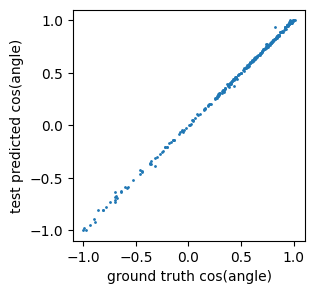

In [9]:
plt.figure(figsize = (3, 3))
plt.plot(predictions_test, targets_test, 'o', markersize = 1)
plt.xlabel("ground truth cos(angle)")
plt.ylabel("test predicted cos(angle)")
plt.savefig("predictions.png", dpi = 900, bbox_inches = 'tight')
plt.show()